# Import libraries and dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold, GridSearchCV, train_test_split

from sklearn.metrics import mean_squared_error

from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU, ReLU, BatchNormalization
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [3]:
# Apparently you may use different seed values at each stage
seed_value=42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [7]:
df = pd.read_excel('/content/drive/MyDrive/datapoints-final.xlsx')

In [8]:
df

,x_measurement,y_measurement,x_theoretical,y_theoretical,x_d1_m1,y_d1_m1,x_d2_m1,y_d2_m1,x_d1_m2,y_d1_m2,x_d2_m2,y_d2_m2
0,43.5,40.0,44.9,39.3,43.38,39.49,43.84,39.18,44.01,40.12,44.65,40.05
1,42.1,17.5,40.4,17.8,41.16,17.30,41.74,16.83,41.67,17.69,42.32,17.48
2,21.6,35.2,21.8,36.1,20.23,34.94,20.45,34.36,20.68,35.27,20.83,35.03
3,46.7,6.6,46.5,7.1,45.60,5.46,46.30,5.15,46.16,6.02,46.80,5.84
4,41.9,26.8,42.2,27.6,40.69,26.66,41.22,26.24,41.31,27.20,41.78,26.80
...,...,...,...,...,...,...,...,...,...,...,...,...
94,112.2,70.3,112.4,69.4,112.95,70.40,113.95,71.26,112.73,71.41,113.75,72.45
95,110.8,45.8,110.1,45.9,110.88,47.64,111.29,46.05,110.28,48.43,110.69,47.02
96,109.3,66.6,108.4,66.0,109.45,68.04,109.86,66.44,109.02,69.00,109.43,67.42
97,134.7,58.2,133.7,58.1,135.48,59.83,136.17,58.32,134.79,60.41,135.39,59.37


# Pre-process

In [9]:
X = df.drop(['x_measurement', 'y_measurement', 'x_theoretical', 'y_theoretical'], axis=1)
y = df[['x_measurement', 'y_measurement']]

Distribution of points on the board: 


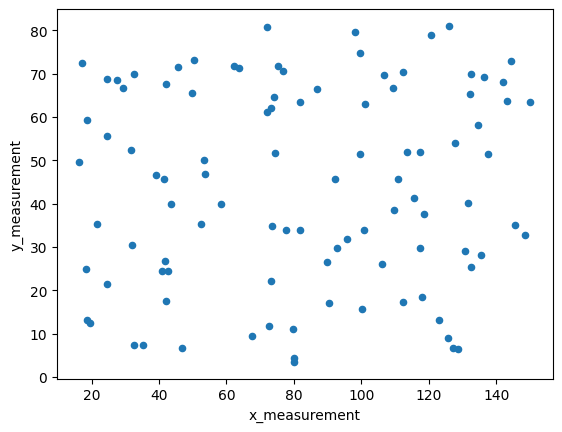

In [107]:
print('Distribution of points on the board: ')
df.plot(kind='scatter', x='x_measurement', y='y_measurement')
plt.xlabel('x_measurement')
plt.ylabel('y_measurement')
plt.show()

del df

In [41]:
random_seed = 3000
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.37)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=random_seed)
print(X_train.shape, X_val.shape, X_test.shape)

(62, 8) (19, 8) (18, 8)


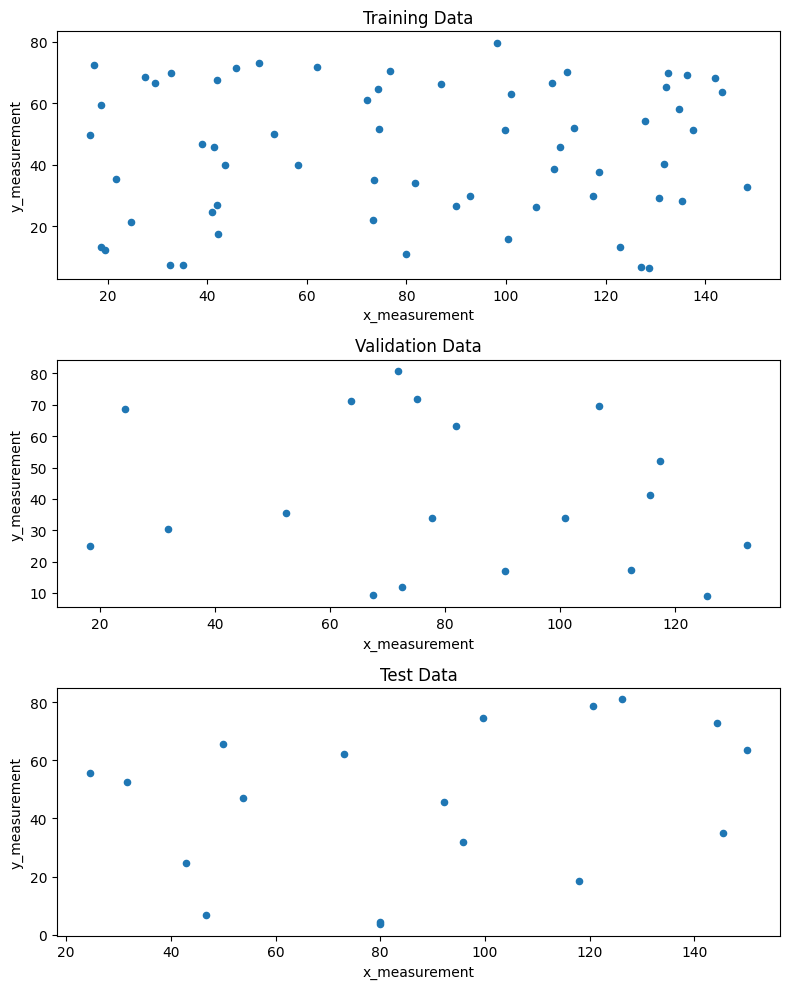

In [42]:
fig, axs = plt.subplots(3, 1, figsize=(8, 10))

# Plot the df_train data on the first subplot
y_train.plot(kind='scatter', x='x_measurement', y='y_measurement', ax=axs[0])
axs[0].set_title('Training Data')

# Plot the df_val data on the second subplot
y_val.plot(kind='scatter', x='x_measurement', y='y_measurement', ax=axs[1])
axs[1].set_title('Validation Data')

# Plot the df_test data on the third subplot
y_test.plot(kind='scatter', x='x_measurement', y='y_measurement', ax=axs[2])
axs[2].set_title('Test Data')

# Add x-axis and y-axis labels to all subplots
for ax in axs.flat:
    ax.set(xlabel='x_measurement', ylabel='y_measurement')

# Adjust the padding between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Hyperparameter tuning

- Hyperparameters importance are (as for Andrew Ng):

    1. Learning rate.
    2. Momentum beta.
    3. Mini-batch size.
    4. No. of hidden units.
    5. No. of layers.
    6. Learning rate decay.
    7. Regularization lambda.

    8. Activation functions.
    9. Adam beta1 & beta2.



- Tuning Learning Rate

Streaming output truncated to the last 5000 lines.
1/1 - 0s - loss: 0.1112 - mse: 0.1112 - val_loss: 0.3946 - val_mse: 0.3946 - 46ms/epoch - 46ms/step
Epoch 503/1500
1/1 - 0s - loss: 0.1112 - mse: 0.1112 - val_loss: 0.3905 - val_mse: 0.3905 - 42ms/epoch - 42ms/step
Epoch 504/1500
1/1 - 0s - loss: 0.1112 - mse: 0.1112 - val_loss: 0.3873 - val_mse: 0.3873 - 43ms/epoch - 43ms/step
Epoch 505/1500
1/1 - 0s - loss: 0.1112 - mse: 0.1112 - val_loss: 0.3834 - val_mse: 0.3834 - 42ms/epoch - 42ms/step
Epoch 506/1500
1/1 - 0s - loss: 0.1111 - mse: 0.1111 - val_loss: 0.3805 - val_mse: 0.3805 - 43ms/epoch - 43ms/step
Epoch 507/1500
1/1 - 0s - loss: 0.1111 - mse: 0.1111 - val_loss: 0.3768 - val_mse: 0.3768 - 44ms/epoch - 44ms/step
Epoch 508/1500
1/1 - 0s - loss: 0.1110 - mse: 0.1110 - val_loss: 0.3732 - val_mse: 0.3732 - 41ms/epoch - 41ms/step
Epoch 509/1500
1/1 - 0s - loss: 0.1110 - mse: 0.1110 - val_loss: 0.3705 - val_mse: 0.3705 - 63ms/epoch - 63ms/step
Epoch 510/1500
1/1 - 0s - loss: 0.1110 - mse

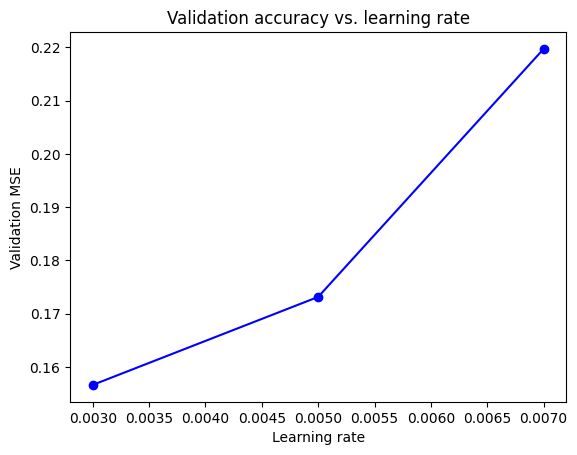

In [59]:
# Define the MLP model
def create_model(lr):
    model = Sequential()
    model.add(Dense(units=128, activation='relu', input_shape=(8,)))
    model.add(BatchNormalization())
    model.add(Dense(units=2, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=lr), metrics=['mse'])
    return model

# Set the common training parameters
epochs = 1500
batch_size = 64
patience = 50

# Set the different learning rates to try
learning_rates = [0.003, 0.005, 0.007]

# Train and evaluate the models with different learning rates
val_accs = []
for lr in learning_rates:
    print("Training model with learning rate {}...".format(lr))
    model = create_model(lr)
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min', restore_best_weights=True)
    history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[early_stop])
    val_accs.append(history.history['val_mse'][-1])
    print("Validation mse: {:.4f}".format(val_accs[-1]))

# Plot the validation accuracy for each learning rate
plt.plot(learning_rates, val_accs, 'bo-')
plt.title('Validation accuracy vs. learning rate')
plt.xlabel('Learning rate')
plt.ylabel('Validation MSE')
plt.show()

- Momentum

Streaming output truncated to the last 5000 lines.
1/1 - 0s - loss: 0.0917 - mse: 0.0917 - val_loss: 0.2256 - val_mse: 0.2256 - 42ms/epoch - 42ms/step
Epoch 857/1800
1/1 - 0s - loss: 0.0917 - mse: 0.0917 - val_loss: 0.2279 - val_mse: 0.2279 - 61ms/epoch - 61ms/step
Epoch 858/1800
1/1 - 0s - loss: 0.0917 - mse: 0.0917 - val_loss: 0.2256 - val_mse: 0.2256 - 58ms/epoch - 58ms/step
Epoch 859/1800
1/1 - 0s - loss: 0.0916 - mse: 0.0916 - val_loss: 0.2276 - val_mse: 0.2276 - 44ms/epoch - 44ms/step
Epoch 860/1800
1/1 - 0s - loss: 0.0916 - mse: 0.0916 - val_loss: 0.2260 - val_mse: 0.2260 - 47ms/epoch - 47ms/step
Epoch 861/1800
1/1 - 0s - loss: 0.0916 - mse: 0.0916 - val_loss: 0.2281 - val_mse: 0.2281 - 43ms/epoch - 43ms/step
Epoch 862/1800
1/1 - 0s - loss: 0.0916 - mse: 0.0916 - val_loss: 0.2259 - val_mse: 0.2259 - 40ms/epoch - 40ms/step
Epoch 863/1800
1/1 - 0s - loss: 0.0916 - mse: 0.0916 - val_loss: 0.2275 - val_mse: 0.2275 - 47ms/epoch - 47ms/step
Epoch 864/1800
1/1 - 0s - loss: 0.0916 - mse

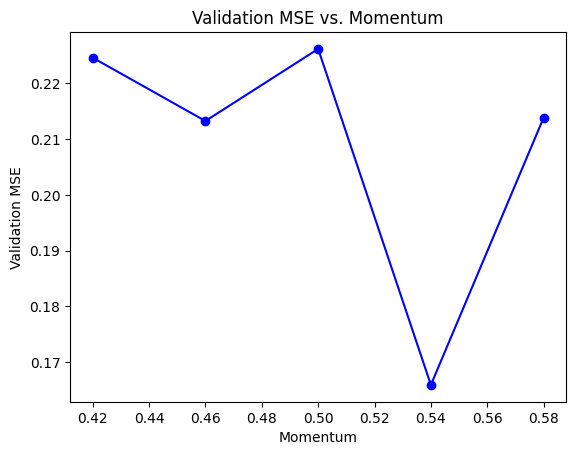

In [60]:
# Define the MLP model
def create_model(beta):
    model = Sequential()
    model.add(Dense(units=128, activation='relu', input_shape=(8,)))
    model.add(BatchNormalization())
    model.add(Dense(units=2, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate= 0.003, momentum=beta, nesterov=True), metrics=['mse'])
    return model

# Set the common training parameters
epochs = 1800
batch_size = 64
patience = 50

# Set the different beta values to try
beta_values = [0.42, 0.46, 0.5, 0.54, 0.58]

# Train and evaluate the models with different beta values
val_accs = []
for beta in beta_values:
    print("Training model with momentum {}...".format(beta))
    model = create_model(beta)
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min', restore_best_weights=True)
    history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[early_stop])
    val_accs.append(history.history['val_mse'][-1])
    print("Validation mse: {:.4f}".format(val_accs[-1]))

# Plot the validation accuracy for each learning rate
plt.plot(beta_values, val_accs, 'bo-')
plt.title('Validation MSE vs. Momentum')
plt.xlabel('Momentum')
plt.ylabel('Validation MSE')
plt.show()

Streaming output truncated to the last 5000 lines.
1/1 - 0s - loss: 0.1019 - mse: 0.1019 - val_loss: 1.2038 - val_mse: 1.2038 - 70ms/epoch - 70ms/step
Epoch 459/1800
1/1 - 0s - loss: 0.1019 - mse: 0.1019 - val_loss: 1.1913 - val_mse: 1.1913 - 70ms/epoch - 70ms/step
Epoch 460/1800
1/1 - 0s - loss: 0.1018 - mse: 0.1018 - val_loss: 1.1681 - val_mse: 1.1681 - 69ms/epoch - 69ms/step
Epoch 461/1800
1/1 - 0s - loss: 0.1018 - mse: 0.1018 - val_loss: 1.1584 - val_mse: 1.1584 - 64ms/epoch - 64ms/step
Epoch 462/1800
1/1 - 0s - loss: 0.1018 - mse: 0.1018 - val_loss: 1.1368 - val_mse: 1.1368 - 66ms/epoch - 66ms/step
Epoch 463/1800
1/1 - 0s - loss: 0.1018 - mse: 0.1018 - val_loss: 1.1248 - val_mse: 1.1248 - 79ms/epoch - 79ms/step
Epoch 464/1800
1/1 - 0s - loss: 0.1018 - mse: 0.1018 - val_loss: 1.1051 - val_mse: 1.1051 - 64ms/epoch - 64ms/step
Epoch 465/1800
1/1 - 0s - loss: 0.1017 - mse: 0.1017 - val_loss: 1.0931 - val_mse: 1.0931 - 76ms/epoch - 76ms/step
Epoch 466/1800
1/1 - 0s - loss: 0.1017 - mse

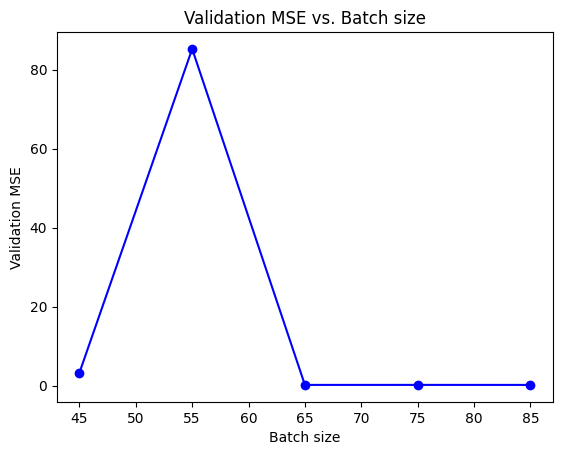

In [61]:
# Define the MLP model
def create_model():
    model = Sequential()
    model.add(Dense(units=128, activation='relu', input_shape=(8,)))
    model.add(BatchNormalization())
    model.add(Dense(units=2, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate= 0.003, momentum=0.54, nesterov=True), metrics=['mse'])
    return model

# Set the common training parameters
epochs = 1800
patience = 50

# Set the different batch sizes to try
batch_sizes = [45, 55, 65, 75, 85]

# Train and evaluate the models with different batch sizes
val_accs = []
for batch_size in batch_sizes:
    print("Training model with batch size {}...".format(batch_size))
    model = create_model()
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min', restore_best_weights=True)
    history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[early_stop])
    val_accs.append(history.history['val_mse'][-1])
    print("Validation mse: {:.4f}".format(val_accs[-1]))

# Plot the validation accuracy for each learning rate
plt.plot(batch_sizes, val_accs, 'bo-')
plt.title('Validation MSE vs. Batch size')
plt.xlabel('Batch size')
plt.ylabel('Validation MSE')
plt.show()

- hidden units

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 74ms/step - loss: 0.1359 - mse: 0.1359 - val_loss: 97.2062 - val_mse: 97.2062
Epoch 128/2500
1/1 [==============================] - 0s 76ms/step - loss: 0.1357 - mse: 0.1357 - val_loss: 96.2425 - val_mse: 96.2425
Epoch 129/2500
1/1 [==============================] - 0s 56ms/step - loss: 0.1356 - mse: 0.1356 - val_loss: 95.2705 - val_mse: 95.2705
Epoch 130/2500
1/1 [==============================] - 0s 74ms/step - loss: 0.1354 - mse: 0.1354 - val_loss: 94.2999 - val_mse: 94.2999
Epoch 131/2500
1/1 [==============================] - 0s 56ms/step - loss: 0.1353 - mse: 0.1353 - val_loss: 93.3597 - val_mse: 93.3597
Epoch 132/2500
1/1 [==============================] - 0s 56ms/step - loss: 0.1351 - mse: 0.1351 - val_loss: 92.3951 - val_mse: 92.3951
Epoch 133/2500
1/1 [==============================] - 0s 79ms/step - loss: 0.1350 - mse: 0.1350 - val_loss: 91.4613 - val_mse: 91.4613
Epoch 134/2500
1/1 

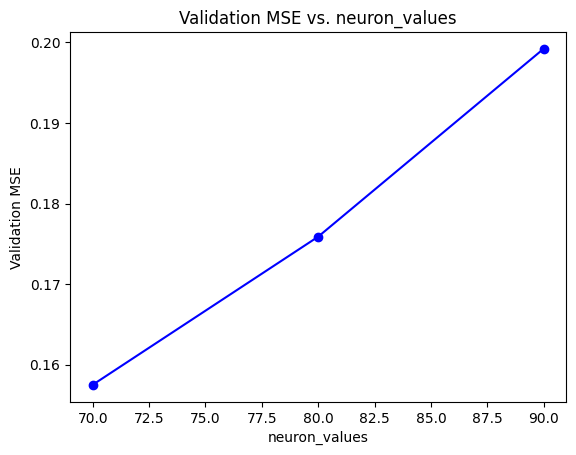

In [64]:
# Define the MLP model
def create_model(num_neurons):
    model = Sequential()
    model.add(Dense(units=num_neurons, activation='relu', input_shape=(8,)))
    model.add(BatchNormalization())
    model.add(Dense(units=2, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate= 0.003, momentum=0.54, nesterov=True), metrics=['mse'])
    return model

# Set the common training parameters
epochs = 2500
patience = 50
batch_size = 64

# Set the different number of neurons to try
neuron_values = [70, 80, 90]

# Train and evaluate the models with different number of neurons
val_accs = []
for num_neurons in neuron_values:
    print("Training model with {} neurons...".format(num_neurons))
    model = create_model(num_neurons)
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min', restore_best_weights=True)
    history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stop])
    val_accs.append(history.history['val_mse'][-1])
    print("Validation mse: {:.4f}".format(val_accs[-1]))

# Plot the validation accuracy for each learning rate
plt.plot(neuron_values, val_accs, 'bo-')
plt.title('Validation MSE vs. neuron_values')
plt.xlabel('neuron_values')
plt.ylabel('Validation MSE')
plt.show()

- num of hidden layers

Training model with 1 layers...
Epoch 1/2000
1/1 [==============================] - 2s 2s/step - loss: 5384.5439 - mse: 5384.5439 - val_loss: 4728.8086 - val_mse: 4728.8086
Epoch 2/2000
1/1 [==============================] - 0s 133ms/step - loss: 4932.0854 - mse: 4932.0854 - val_loss: 4407.6421 - val_mse: 4407.6421
Epoch 3/2000
1/1 [==============================] - 0s 113ms/step - loss: 4426.7007 - mse: 4426.7007 - val_loss: 3756.4519 - val_mse: 3756.4519
Epoch 4/2000
1/1 [==============================] - 0s 113ms/step - loss: 3619.2688 - mse: 3619.2688 - val_loss: 2609.7361 - val_mse: 2609.7361
Epoch 5/2000
1/1 [==============================] - 0s 167ms/step - loss: 2420.7632 - mse: 2420.7632 - val_loss: 1236.1672 - val_mse: 1236.1672
Epoch 6/2000
1/1 [==============================] - 0s 118ms/step - loss: 1081.4760 - mse: 1081.4760 - val_loss: 380.5978 - val_mse: 380.5978
Epoch 7/2000
1/1 [==============================] - 0s 121ms/step - loss: 189.6729 - mse: 189.6729 - val_loss

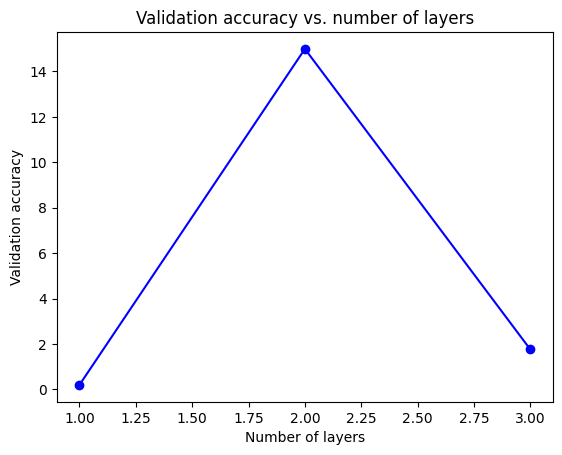

In [67]:
# Define the MLP model
def create_model(num_layers):
    model = Sequential()

    for i in range(num_layers):
        model.add(Dense(units=70//(i+1), activation='relu'))
        model.add(BatchNormalization())

    model.add(Dense(units=2, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate= 0.003, momentum=0.54, nesterov=True), metrics=['mse'])
    return model

# Set the common training parameters
epochs = 2000
patience = 50
batch_size = 64

# Set the different number of layers to try
layer_values = [1, 2, 3]

# Train and evaluate the models with different numbers of layers
val_accs = []
for num_layers in layer_values:
    print("Training model with {} layers...".format(num_layers))
    model = create_model(num_layers)
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min', restore_best_weights=True)
    history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stop])
    val_accs.append(history.history['val_mse'][-1])
    print("Validation mse: {:.4f}".format(val_accs[-1]))


# Plot the validation accuracy for each number of layers
plt.plot(layer_values, val_accs, 'bo-')
plt.title('Validation accuracy vs. number of layers')
plt.xlabel('Number of layers')
plt.ylabel('Validation accuracy')
plt.show()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 111ms/step - loss: 0.2381 - mse: 0.1077 - val_loss: 0.3193 - val_mse: 0.1889 - lr: 0.0015
Epoch 794/2000
1/1 [==============================] - 0s 88ms/step - loss: 0.2381 - mse: 0.1077 - val_loss: 0.3193 - val_mse: 0.1889 - lr: 0.0015
Epoch 795/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.2381 - mse: 0.1077 - val_loss: 0.3193 - val_mse: 0.1889 - lr: 0.0015
Epoch 796/2000
1/1 [==============================] - 0s 86ms/step - loss: 0.2381 - mse: 0.1077 - val_loss: 0.3191 - val_mse: 0.1887 - lr: 0.0015
Epoch 797/2000
1/1 [==============================] - 0s 84ms/step - loss: 0.2381 - mse: 0.1077 - val_loss: 0.3192 - val_mse: 0.1888 - lr: 0.0015
Epoch 798/2000
1/1 [==============================] - 0s 91ms/step - loss: 0.2381 - mse: 0.1077 - val_loss: 0.3190 - val_mse: 0.1887 - lr: 0.0015
Epoch 799/2000
1/1 [==============================] - 0s 113ms/step - loss: 0.2381 - m

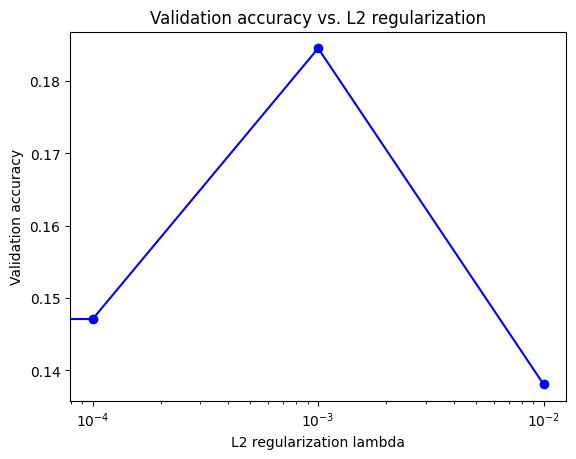

In [73]:
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l2

# Define the MLP model
def create_model(l2_lambda):
    model = Sequential()

    model.add(Dense(units=70, activation='relu', input_shape=(8,), kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())

    model.add(Dense(units=2, activation='linear', kernel_regularizer=l2(l2_lambda)))
    model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate= 0.003, momentum=0.54, nesterov=True), metrics=['mse'])
    return model

# Set the common training parameters
epochs = 2000
patience = 50
batch_size = 64

# Define the learning rate schedule
def lr_schedule(epoch):
    lr = 0.003 * np.power(0.5, epoch // 600)
    return lr

# Set the range of L2 regularization parameter values to try
l2_range = [0, 0.0001, 0.001, 0.01]

# Train and evaluate the models with different L2 regularization parameter values
val_accs = []
for l2_lambda in l2_range:
    print("Training model with L2 regularization lambda={}...".format(l2_lambda))
    model = create_model(l2_lambda)
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min', restore_best_weights=True)
    lr_scheduler = LearningRateScheduler(lr_schedule)
    history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stop, lr_scheduler])
    val_accs.append(history.history['val_mse'][-1])
    print("Validation mse: {:.4f}".format(val_accs[-1]))

# Plot the validation accuracy for each regularization parameter value
plt.plot(l2_range, val_accs, 'bo-')
plt.title('Validation accuracy vs. L2 regularization')
plt.xlabel('L2 regularization lambda')
plt.ylabel('Validation accuracy')
plt.xscale('log')
plt.show()

In [74]:
val_accs

[0.16025254130363464,
 0.14708733558654785,
 0.18451018631458282,
 0.13806258141994476]

# Train the Model

In [97]:
model = Sequential()

model.add(Dense(units=70, activation='relu', input_shape=(8,), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(units=2, activation='linear', kernel_regularizer=l2(0.01)))
model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate= 0.003, momentum=0.54, nesterov=True), metrics=['mse'])

model.summary()

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_159 (Dense)           (None, 70)                630       
                                                                 
 batch_normalization_80 (Bat  (None, 70)               280       
 chNormalization)                                                
                                                                 
 dense_160 (Dense)           (None, 2)                 142       
                                                                 
Total params: 1,052
Trainable params: 912
Non-trainable params: 140
_________________________________________________________________


In [98]:
# Set the common training parameters
epochs = 5000
patience = 50
batch_size = 64

# Define the learning rate schedule
def lr_schedule(epoch):
    lr = 0.003 * np.power(0.8, epoch // 400)
    return lr

early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min', restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lr_schedule)
history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[early_stop, lr_scheduler])

Streaming output truncated to the last 5000 lines.
Epoch 2501/5000
1/1 - 0s - loss: 1.1411 - mse: 0.0768 - val_loss: 1.2143 - val_mse: 0.1500 - lr: 7.8643e-04 - 65ms/epoch - 65ms/step
Epoch 2502/5000
1/1 - 0s - loss: 1.1410 - mse: 0.0768 - val_loss: 1.2143 - val_mse: 0.1500 - lr: 7.8643e-04 - 51ms/epoch - 51ms/step
Epoch 2503/5000
1/1 - 0s - loss: 1.1410 - mse: 0.0768 - val_loss: 1.2142 - val_mse: 0.1500 - lr: 7.8643e-04 - 47ms/epoch - 47ms/step
Epoch 2504/5000
1/1 - 0s - loss: 1.1410 - mse: 0.0767 - val_loss: 1.2141 - val_mse: 0.1499 - lr: 7.8643e-04 - 52ms/epoch - 52ms/step
Epoch 2505/5000
1/1 - 0s - loss: 1.1409 - mse: 0.0767 - val_loss: 1.2139 - val_mse: 0.1498 - lr: 7.8643e-04 - 44ms/epoch - 44ms/step
Epoch 2506/5000
1/1 - 0s - loss: 1.1409 - mse: 0.0767 - val_loss: 1.2140 - val_mse: 0.1498 - lr: 7.8643e-04 - 63ms/epoch - 63ms/step
Epoch 2507/5000
1/1 - 0s - loss: 1.1409 - mse: 0.0767 - val_loss: 1.2139 - val_mse: 0.1498 - lr: 7.8643e-04 - 63ms/epoch - 63ms/step
Epoch 2508/5000
1/

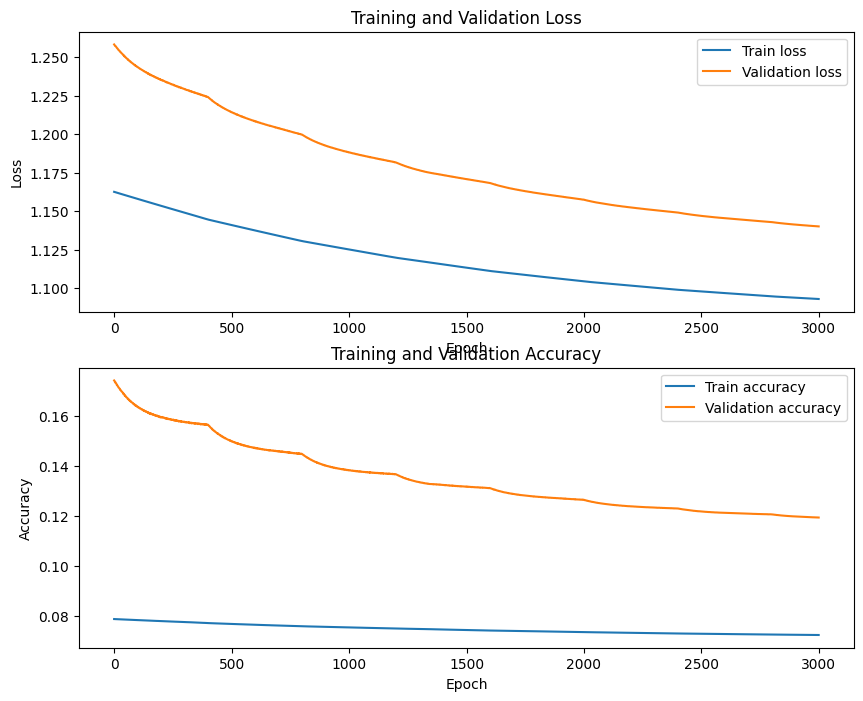

In [101]:
plt.figure(figsize=(10, 8))

# Plot the training and validation loss
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'][-3000:], label='Train loss')
plt.plot(history.history['val_loss'][-3000:], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(2, 1, 2)
plt.plot(history.history['mse'][-3000:], label='Train accuracy')
plt.plot(history.history['val_mse'][-3000:], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Results

In [100]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# make predictions on the training and test data
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# evaluate the training set performance
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Train set MSE: {train_mse:.3f}")
print(f"Train set MAE: {train_mae:.3f}")
print(f"Train set R-squared: {train_r2:.3f}")
print("================================")

# evaluate the validation set performance
val_mse = mean_squared_error(y_val, y_val_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation set MSE: {val_mse:.3f}")
print(f"Validation set MAE: {val_mae:.3f}")
print(f"Validation set R-squared: {val_r2:.3f}")
print("================================")

# evaluate the test set performance
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test set MSE: {test_mse:.3f}")
print(f"Test set MAE: {test_mae:.3f}")
print(f"Test set R-squared: {test_r2:.3f}")

1/1 [==============================] - 0s 40ms/step
Train set MSE: 0.074
Train set MAE: 0.200
Train set R-squared: 1.000
Validation set MSE: 0.119
Validation set MAE: 0.265
Validation set R-squared: 1.000
Test set MSE: 0.216
Test set MAE: 0.343
Test set R-squared: 1.000


In [105]:
# model.save_weights('/content/drive/MyDrive/my_mlp_model.h5')

In [103]:
print("real label of points in the test set: ")
y_test

real label of points in the test set: 


,x_measurement,y_measurement
80,99.7,74.7
63,31.6,52.4
26,95.8,31.9
85,120.6,78.8
82,150.1,63.4
38,145.4,35.1
76,73.1,62.1
84,144.3,73.0
23,80.0,4.5
43,117.9,18.5


In [104]:
print("predicted label of points in the test set using the model: ")
test_results_df = pd.DataFrame(y_test_pred)
test_results_df.style.format("{:.1f}")

predicted label of points in the test set using the model: 


,0,1
0,99.7,75.5
1,31.4,51.2
2,96.5,31.8
3,120.2,79.1
4,150.0,63.4
5,145.3,35.1
6,73.3,62.3
7,144.5,72.0
8,80.3,4.5
9,118.0,19.2


# ignore it

In [ ]:
# !pip install keras-tuner

In [ ]:
# import math
# import pandas as pd
# import tensorflow as tf
# import matplotlib.pyplot as plt
# from keras import Model
# from keras import Sequential
# from keras.optimizers import Adam
# from sklearn.preprocessing import StandardScaler
# from keras.layers import Dense, Dropout
# from sklearn.model_selection import train_test_split
# from keras.losses import MeanSquaredError

In [ ]:
# def scale_datasets(x_train, x_test):
#   """
#   Standard Scale test and train data
#   Z - Score normalization
#   """
#   standard_scaler = StandardScaler()
#   x_train_scaled = pd.DataFrame(
#       standard_scaler.fit_transform(x_train),
#       columns=x_train.columns
#   )
#   x_test_scaled = pd.DataFrame(
#       standard_scaler.transform(x_test),
#       columns = x_test.columns
#   )
#   return x_train_scaled, x_test_scaled

# # scale the dataset
# x_train_scaled, x_test_scaled = scale_datasets(X_train, X_test)

In [ ]:
# # Add the first hidden layer with 64 units and LeakyReLU activation
# model.add(Dense(units=64, input_dim=8, kernel_regularizer=regularizers.l2(0.01)))
# model.add(LeakyReLU(alpha=0.1))
# model.add(Dropout(rate=0.05))

# # Add the second hidden layer with 32 units and LeakyReLU activation
# model.add(Dense(units=32, kernel_regularizer=regularizers.l2(0.01)))
# model.add(LeakyReLU(alpha=0.1))
# model.add(Dropout(rate=0.05))

# # Add the output layer with 2 units and linear activation
# model.add(Dense(units=2, activation='linear'))

# # Compile the model
# model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [ ]:
# import kerastuner as kt
# msle = MeanSquaredError()
# from kerastuner import HyperModel


# class ANNHyperModel(HyperModel):

#     def build(self, hp):
#       model = Sequential()
#       # Tune the number of units in the first Dense layer
#       # Choose an optimal value between 32-512
#       hp_units1 = hp.Int('units1', min_value=8, max_value=48, step=4)
#       hp_units2 = hp.Int('units2', min_value=4, max_value=32, step=4)

#       hp_regularization = hp.Choice('regularization', values=[1e-1, 1e-2, 1e-3, 1e-4])

#       model.add(Dense(units=hp_units1, activation='relu', kernel_regularizer=regularizers.l2(hp_regularization)))
#       model.add(Dropout(rate=0.2))

#       # Add the second hidden layer with ReLU activation and L2 regularization
#       model.add(Dense(units=hp_units2, activation='relu', kernel_regularizer=regularizers.l2(hp_regularization)))
#       model.add(Dropout(rate=0.2))

#       model.add(Dense(2, kernel_initializer='normal', activation='linear'))

#       # Tune the learning rate for the optimizer
#       # Choose an optimal value from 0.01, 0.001, or 0.0001
#       hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#       model.compile(
#           optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
#           loss=msle,
#           metrics=[msle]
#       )

#       return model

# hypermodel = ANNHyperModel()

# tuner = kt.Hyperband(
#     hypermodel,
#     objective='val_mean_squared_error',
#     max_epochs=100,
#     factor=3,
#     directory='keras_tuner_dir',
#     project_name='keras_tuner_demo2'
# )

# tuner.search(X_train_scaled, y_train, epochs=100, validation_split=0.1, verbose=2)


Search: Running Trial #307

Value             |Best Value So Far |Hyperparameter
48                |48                |units1
12                |20                |units2
0.01              |0.1               |learning_rate
0.1               |None              |regularization
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
6                 |6                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


KeyboardInterrupt: ignored

In [ ]:
# for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
#   print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 32
units2 96
units3 64
learning_rate 0.01


In [ ]:
# for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
#   print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 384
units2 352
units3 64
learning_rate 0.01
